# 基础因子实时计算

zz500模拟盘操作

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
sys.path.append('../../../../')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

from PyFin.api import *
from alphamind.api import *
from conf.models import *
from conf.config import*
from data.engines.model import Record
from alphamind.execution.naiveexecutor import NaiveExecutor
from stacking import factor_store, feature_list
from optimization.bayes_optimization_xgb import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)


## 因子数据准备

In [2]:
# 设置train和predict日期
start_date = '2019-10-30'  # trainning起始时间
end_date = '2020-01-13'    # predict时间, 调仓日

# 设置交易日
trade_end_date = '2020-01-14'        # 当前交易日期[predict的下一个交易日作为下单调仓日]

# 设置保存的文件目录
weekly = 's_1'  # 文件目录
freq = '1b'

# 换手率控制
turn_over_rate = 0.2  # {s1:0.5, s2:0.3, s3:0.6, s4:0.8, s5:0.5}

# 组合优化参数
weight_gap = 0.02

In [3]:
universe = Universe('zz500')
benchmark_code = 905
ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
horizon = map_freq(freq)
industry_name = 'sw'
industry_level = 1

# 根据索引删除某些特殊日期{节假日, 零时停盘日等}
trash_date_list = [datetime(2020, 1, 1, 0, 0)]
a = []
for i in trash_date_list:
    try:
        del(ref_dates[ref_dates.index(i)])
    except:
        continue

# 前一个调仓日
ref_date_pre = ref_dates[-2]
# 当前调仓日
ref_date = ref_dates[-1]
print('前一个调仓日: %s' % ref_date_pre)
print('当前调仓日: %s' % ref_date)

# 获取前一个交易日, 用于获取前一个调仓日的持仓信息
date_range = makeSchedule(ref_date_pre, trade_end_date, '1d', 'china.sse')
# 前一个交易日, 如果遇到上一个调仓日存在空缺如[2020.01.01], 需要特殊指定
adjusted_date_pre = datetime(2020, 1, 11, 0, 0)
# adjusted_date_pre = date_range[1]
# 当前交易日
adjusted_date = date_range[-1]

print('前一个交易日: %s' % adjusted_date_pre)
print('当前交易日: %s' % adjusted_date)

前一个调仓日: 2020-01-10 00:00:00
当前调仓日: 2020-01-13 00:00:00
前一个交易日: 2020-01-11 00:00:00
当前交易日: 2020-01-14 00:00:00


In [4]:
# 因子数据库
data_source = alpha_db
engine = SqlEngine(data_source)

# uqer因子列表
basic_factor_store = factor_store.basic_factor_store
# alpha191因子列表
alpha_factor_store = factor_store.alpha_factor_store

In [5]:
%%time
# 提取Uqer因子
basic_factor_org = engine.fetch_factor_range(universe, basic_factor_store, dates=ref_dates)
# 提取alpha191因子
# alpha191_factor_org = engine.fetch_factor_range(universe, 
#                                                 alpha_factor_store, 
#                                                 dates=ref_dates, 
#                                                 used_factor_tables=[Alpha191]).drop(['chgPct','secShortName'], axis=1)
# # 合并所有的因子
# factor_data_org = pd.merge(basic_factor_org, alpha191_factor_org, on=['trade_date', 'code'], how='outer')
factor_data_org = basic_factor_org


CPU times: user 57.6 s, sys: 1.4 s, total: 59 s
Wall time: 1min 5s


In [6]:
set(factor_data_org['trade_date'])

{Timestamp('2019-10-30 00:00:00'),
 Timestamp('2019-10-31 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-11-04 00:00:00'),
 Timestamp('2019-11-05 00:00:00'),
 Timestamp('2019-11-06 00:00:00'),
 Timestamp('2019-11-07 00:00:00'),
 Timestamp('2019-11-08 00:00:00'),
 Timestamp('2019-11-11 00:00:00'),
 Timestamp('2019-11-12 00:00:00'),
 Timestamp('2019-11-13 00:00:00'),
 Timestamp('2019-11-14 00:00:00'),
 Timestamp('2019-11-15 00:00:00'),
 Timestamp('2019-11-18 00:00:00'),
 Timestamp('2019-11-19 00:00:00'),
 Timestamp('2019-11-20 00:00:00'),
 Timestamp('2019-11-21 00:00:00'),
 Timestamp('2019-11-22 00:00:00'),
 Timestamp('2019-11-25 00:00:00'),
 Timestamp('2019-11-26 00:00:00'),
 Timestamp('2019-11-27 00:00:00'),
 Timestamp('2019-11-28 00:00:00'),
 Timestamp('2019-11-29 00:00:00'),
 Timestamp('2019-12-02 00:00:00'),
 Timestamp('2019-12-03 00:00:00'),
 Timestamp('2019-12-04 00:00:00'),
 Timestamp('2019-12-05 00:00:00'),
 Timestamp('2019-12-06 00:00:00'),
 Timestamp('2019-12-

In [7]:
assert len(set(factor_data_org['trade_date'])) == len(ref_dates)


Text(0, 0.5, 'ACCA')

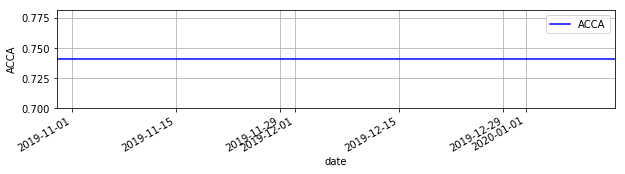

In [8]:
# Plot factor value over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = factor_data_org[factor_data_org['code'] == 6].plot(x='trade_date', y='ACCA', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("ACCA")

In [9]:
# 因子预处理
## 确失值填充
factor_mean = factor_data_org.mean()
factor_std = factor_data_org.std()
factor_data_org = factor_data_org.fillna(factor_mean)

In [10]:
%%time
# 获取所属行业
industry = engine.fetch_industry_range(universe, dates=ref_dates)
# factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code']).fillna(0.)
factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code'])

# 获取风险因子
risk_total = engine.fetch_risk_model_range(universe, dates=ref_dates)[1]


CPU times: user 670 ms, sys: 38.8 ms, total: 709 ms
Wall time: 1.22 s


In [11]:
%%time
return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0, benchmark = benchmark_code)
# return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0)


CPU times: user 256 ms, sys: 6.37 ms, total: 262 ms
Wall time: 572 ms


In [12]:
return_data.head()

,trade_date,code,dx
0,2019-10-30,6,0.008077
52,2019-10-30,8,0.000362
104,2019-10-30,9,-0.004680
156,2019-10-30,12,0.006179
208,2019-10-30,21,-0.017192


In [13]:
%%time
benchmark_total = engine.fetch_benchmark_range(dates=ref_dates, benchmark=benchmark_code)
industry_total = engine.fetch_industry_matrix_range(universe, dates=ref_dates, category=industry_name, level=industry_level)

train_data = pd.merge(factor_data, return_data, on=['trade_date', 'code']).dropna()


CPU times: user 478 ms, sys: 11 ms, total: 489 ms
Wall time: 666 ms


Text(0, 0.5, 'dx')

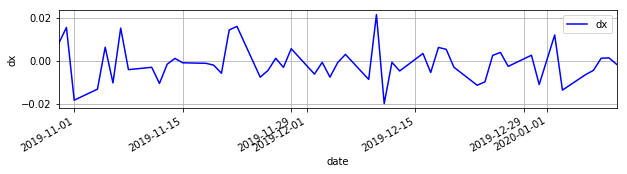

In [14]:
# Plot adjusted close over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = train_data[train_data['code'] == 6].plot(x='trade_date', y='dx', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("dx")

In [15]:
# 获取特征名
features = list(basic_factor_store.keys())
alpha_features = list(alpha_factor_store.keys())
# features = feature_list.uqer_features
# alpha_features = feature_list.alpha_features
# features.extend(alpha_features)

label = ['dx']

## 模型训练

In [16]:
from datetime import datetime, timedelta
from models.m1_xgb import *
from conf.configuration import xgb_conf
from data.engines.model import Record
import xgboost as xgb
import gc

alpha_logger.info('{0} is start'.format(ref_date))

# machine learning model
## Filter Training data
## 训练集构造
trade_date_pre = ref_date - timedelta(days=1)
# trade_date_pre_80 = ref_date - timedelta(days=80)

## 1、选择调仓日当天之前(不含当天)并且在80天以内的因子数据作为训练集.
# train = train_data[(train_data.trade_date <= trade_date_pre) & (trade_date_pre_80 <= train_data.trade_date)].dropna()
## 2、选择调仓日当天之前(不含当天)的因子数据作为训练集.
train = train_data[train_data.trade_date <= trade_date_pre].dropna()
alpha_logger.info('trade_date_pre {0}'.format(trade_date_pre))

if len(train) <= 0:
    alpha_logger.info('{0} HAS NO TRAIN DATA!!!'.format(ref_date))

x_train = train[features]
y_train = train[label]
alpha_logger.info('len_x_train: {0}, len_y_train: {1}'.format(len(x_train.values), len(y_train.values)))
alpha_logger.info('X_train.shape={0}, X_test.shape = {1}'.format(np.shape(x_train), np.shape(y_train)))


2020-01-14 01:50:16,223 - ALPHA_MIND - INFO - 2020-01-13 00:00:00 is start
2020-01-14 01:50:16,394 - ALPHA_MIND - INFO - trade_date_pre 2020-01-12 00:00:00
2020-01-14 01:50:16,418 - ALPHA_MIND - INFO - len_x_train: 26000, len_y_train: 26000
2020-01-14 01:50:16,418 - ALPHA_MIND - INFO - X_train.shape=(26000, 423), X_test.shape = (26000, 1)


## 超参寻优

In [17]:
# load xgboost regression configuration
xgb_conf.xgb_config_r()
xgb_conf.cv_folds = None
xgb_conf.early_stop_round = 100
xgb_conf.max_round = 800
xgb_conf.params.update({'nthread': 12})

GPU_device = False
if GPU_device:
    # use GPUs
    xgb_conf.params.update({'tree_method': 'gpu_hist'})
alpha_logger.info("params before: {}".format(xgb_conf.params))
tic = time.time()

# hyper_parameters optimization
# opt_parameters = {'max_depth': (2, 12),
#                   'gamma': (0.001, 10.0),
#                   'min_child_weight': (0, 20),
#                   'max_delta_step': (0, 10),
#                   'subsample': (0.01, 0.99),
#                   'colsample_bytree': (0.01, 0.99)
#                  }

# opt_xgb = BayesOptimizationXGB('regression', x_train, y_train)
# params_op = opt_xgb.train_opt(opt_parameters)
# xgb_conf.params.update(params_op)
alpha_logger.info("params after: {}".format(xgb_conf.params))
alpha_logger.info("hyper params optimize time : {}".format(time.time() - tic))


2020-01-14 01:50:16,425 - ALPHA_MIND - INFO - params before: {'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2020-01-14 01:50:16,426 - ALPHA_MIND - INFO - params after: {'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2020-01-14 01:50:16,427 - ALPHA_MIND - INFO - hyper params optimize time : 0.0006165504455566406


## 模型训练

In [18]:
%%time
# model training
xgb_model = XGBooster(xgb_conf)
alpha_logger.info('xgb_model params: \n{0}'.format(xgb_model.get_params()))

best_score, best_round, best_model = xgb_model.fit(x_train, y_train)
alpha_logger.info('Training time cost {}s'.format(time.time() - tic))
alpha_logger.info('best_score = {}, best_round = {}'.format(best_score, best_round))


2020-01-14 01:50:16,432 - ALPHA_MIND - INFO - xgb_model params: 
{'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2020-01-14 01:50:16,433 - ../../../../models/m1_xgb.py[line:95] - INFO: NonCrossValidation。。。。


[0]	train-rmse:0.4957	train-logloss:0.683182
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.47144	train-logloss:0.636192
[10]	train-rmse:0.448368	train-logloss:0.593457
[15]	train-rmse:0.426431	train-logloss:0.554445
[20]	train-rmse:0.40557	train-logloss:0.518702
[25]	train-rmse:0.385733	train-logloss:0.485851
[30]	train-rmse:0.366867	train-logloss:0.455574
[35]	train-rmse:0.34893	train-logloss:0.427609
[40]	train-rmse:0.331873	train-logloss:0.401717
[45]	train-rmse:0.315658	train-logloss:0.377703
[50]	train-rmse:0.300238	train-logloss:0.355384
[55]	train-rmse:0.285575	train-logloss:0.334607
[60]	train-rmse:0.271635	train-logloss:0.315242
[65]	train-rmse:0.258379	train-logloss:0.297162
[70]	train-rmse:0.245773	train-logloss:0.280262
[75]	train-rmse:0.233791	train-logloss:0.264452
[80]	train-rmse:0.222398	train-logloss:0.249641
[85]	train-rmse:0.211567	train-logloss:

2020-01-14 01:50:36,537 - ALPHA_MIND - INFO - Training time cost 20.110952615737915s
2020-01-14 01:50:36,537 - ALPHA_MIND - INFO - best_score = {'best_score': -0.106314}, best_round = 799


CPU times: user 3min 57s, sys: 363 ms, total: 3min 58s
Wall time: 20.1 s


## 当天数据预测

In [19]:
# 取调仓日当天的因子数据作为输入.
# total_data_test_excess = train_data[train_data.trade_date == str(ref_date)]
total_data_test_excess = factor_data[factor_data.trade_date == ref_date]

if len(total_data_test_excess) <=0:
    alpha_logger.info('{} HAS NO DATA!!!'.format(ref_date))
    sys.exit()

alpha_logger.info('{0} total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 获取调仓日当天的行业, 风险模型和基准权重数据
industry_matrix = industry_total[industry_total.trade_date == ref_date]
benchmark_weight = benchmark_total[benchmark_total.trade_date == ref_date]
risk_matrix = risk_total[risk_total.trade_date == ref_date]

total_data = pd.merge(industry_matrix, benchmark_weight, on=['code'], how='left').fillna(0.)
total_data = pd.merge(total_data, risk_matrix, on=['code'])
alpha_logger.info('{0} type_of_total_data: {1}'.format(ref_date, type(total_data)))
alpha_logger.info('{0} shape_of_total_data: {1}'.format(ref_date, np.shape(total_data)))
    
total_data_test_excess = pd.merge(total_data, total_data_test_excess, on=['code'])
alpha_logger.info('{0} len_of_total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 股票代码
codes = total_data_test_excess.code.values.tolist()
   
# predict
# alpha_logger.info('total_data_test_excess: \n{}'.format(total_data_test_excess[['weight', 'code', 'industry']]))
x_pred = total_data_test_excess[features]
predict_xgboost = xgb_model.predict(best_model, x_pred)
# alpha_logger.info('predict_xgboost: {}'.format(predict_xgboost))

a = np.shape(predict_xgboost)
predict_xgboost = np.reshape(predict_xgboost, (a[0], -1)).astype(np.float64)
alpha_logger.info('shape_of_predict_xgboost: {}'.format(np.shape(predict_xgboost)))

# 收益率预测结果    
predict_xgboost_df = pd.DataFrame({'xgb_pre': list(predict_xgboost.reshape(-1))})
predict_xgboost_df['trade_date'] = ref_date
predict_xgboost_df['code'] = codes
predict_xgboost_df['code'] = predict_xgboost_df['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG'
                                                              if len(str(x))==6 and str(x)[0] in '6' 
                                                              else "{:06d}".format(x) + '.XSHE')


2020-01-14 01:50:36,655 - ALPHA_MIND - INFO - 2020-01-13 00:00:00 total_data_test_excess: 500
2020-01-14 01:50:36,667 - ALPHA_MIND - INFO - 2020-01-13 00:00:00 type_of_total_data: <class 'pandas.core.frame.DataFrame'>
2020-01-14 01:50:36,668 - ALPHA_MIND - INFO - 2020-01-13 00:00:00 shape_of_total_data: (500, 74)
2020-01-14 01:50:36,675 - ALPHA_MIND - INFO - 2020-01-13 00:00:00 len_of_total_data_test_excess: 500
2020-01-14 01:50:36,688 - ALPHA_MIND - INFO - shape_of_predict_xgboost: (500, 1)


## 获取昨持仓信息

In [20]:
from data.engines.sqlengine import SQLEngine

# 获取当前持仓
record_engine = SQLEngine('sqlite:///./{}/real_tune_record_without_alpha.db'.format(weekly))

try:
    pos_record = record_engine.fetch_record('pos_record')
    previous_pos = pos_record[pos_record['trade_date'] == adjusted_date_pre]
#     previous_pos = record_engine.fetch_record_meta(Record, adjusted_date_pre)
    
except Exception as e:
    alpha_logger.info('pos_record Exception:{0}'.format(e))
    previous_pos = pd.DataFrame({'trade_date':[], 'weight':[],'industry':[], 'er':[],'code':[]})

alpha_logger.info('previous_pos_data: {0}, pos_len: {1}'.format(adjusted_date_pre, len(previous_pos)))

# 股票过滤, 组合优化之前过滤掉(未完成)
## 9:00--9:25之间进行涨跌停股票的实时筛选

# 导入昨持仓并与股票池中所有股票合并, 
if len(previous_pos) <= 0:
    current_position = None
else:
    previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left',).fillna(0)
    current_position = previous_pos.weight.values
alpha_logger.info('previous_pos:\n {}'.format(previous_pos))

# previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left').fillna(0)
# current_position = previous_pos.weight.values

# print(current_position.shape)
# print(total_data_test_excess.shape)
# print(previous_pos.shape)

2020-01-14 01:50:36,721 - ALPHA_MIND - INFO - previous_pos_data: 2020-01-11 00:00:00, pos_len: 50
2020-01-14 01:50:36,753 - ALPHA_MIND - INFO - previous_pos:
        code           trade_date    weight industry        er          adjust_date
0         6                    0  0.000000        0  0.000000                    0
1         8                    0  0.000000        0  0.000000                    0
2         9  2020-01-11 00:00:00  0.017303       综合  0.004614  2020-01-10 00:00:00
3        12                    0  0.000000        0  0.000000                    0
4        21                    0  0.000000        0  0.000000                    0
5        25                    0  0.000000        0  0.000000                    0
6        27                    0  0.000000        0  0.000000                    0
7        28                    0  0.000000        0  0.000000                    0
8        31                    0  0.000000        0  0.000000                    0
9        39

## 组合优化

In [21]:
# Constraintes settings
industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['EARNYILD', 'LIQUIDTY', 'GROWTH', 'SIZE', 'SIZENL', 'BETA', 'MOMENTUM'] + industry_names

total_risk_names = constraint_risk + ['benchmark', 'total']

b_type = []
l_val = []
u_val = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.0)
        u_val.append(1.0)
    elif name == 'total':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.0)
        u_val.append(0.0)
    elif name == 'SIZE':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name == 'SIZENL':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name in industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.005)
        u_val.append(0.005)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-2.0)
        u_val.append(2.0)
bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)


In [22]:
%%time
benchmark_w = total_data_test_excess.weight.values
alpha_logger.info('type_of_benchmark_w: {}, shape_of_benchmark_w: {}'.format(type(benchmark_w), 
                                                                             np.shape(benchmark_w)))
is_in_benchmark = (benchmark_w > 0.).astype(float).reshape((-1, 1))

# 风险模型数据合并
total_risk_exp = np.concatenate([total_data_test_excess[constraint_risk].values.astype(float),
                                 is_in_benchmark,
                                 np.ones_like(is_in_benchmark)],
                                axis=1)

alpha_logger.info('shape_of_total_risk_exp_pre: {}'.format(np.shape(total_risk_exp)))
total_risk_exp = pd.DataFrame(total_risk_exp, columns=total_risk_names)
alpha_logger.info('shape_of_total_risk_exp: {}'.format(np.shape(total_risk_exp)))

constraints = LinearConstraints(bounds, total_risk_exp, benchmark_w)
alpha_logger.info('constraints: {0} in {1}'.format(np.shape(constraints.risk_targets()), ref_date))

lbound = np.maximum(0., benchmark_w - weight_gap)
ubound = weight_gap + benchmark_w
alpha_logger.info('lbound: {0} in {1}'.format(np.shape(lbound), ref_date))
alpha_logger.info('ubound: {0} in {1}'.format(np.shape(ubound), ref_date))

# 组合优化
executor = NaiveExecutor()
current_pos = pd.DataFrame()

target_pos, _ = er_portfolio_analysis(predict_xgboost, 
                                      total_data_test_excess['industry'].values,
                                      None,
                                      constraints,
                                      False,
                                      benchmark_w,
                                      method='risk_neutral',
                                      lbound=lbound,
                                      ubound=ubound,
                                      turn_over_target=turn_over_rate,
                                      current_position=current_position)
                  
alpha_logger.info('shape_of_target_pos: {}'.format(np.shape(target_pos)))
alpha_logger.info('len_codes:{}'.format(np.shape(codes)))
target_pos['code'] = codes
# alpha_logger.info('target_pos: \n{}'.format(target_pos))

# 换手率计算
executor.set_current(previous_pos)
turn_over_org, current_pos = executor.execute(target_pos=target_pos)
alpha_logger.info('turn_over_org: {}'.format(turn_over_org))
turn_over = turn_over_org / sum(target_pos.weight.values)
alpha_logger.info('turn_over: {}'.format(turn_over))

# 优化后仓位信息
## 调仓日
current_pos['adjust_date'] = ref_date
## 交易日
current_pos['trade_date'] = adjusted_date
alpha_logger.info('{} is finished'.format(adjusted_date))


2020-01-14 01:50:36,772 - ALPHA_MIND - INFO - type_of_benchmark_w: <class 'numpy.ndarray'>, shape_of_benchmark_w: (500,)
2020-01-14 01:50:36,775 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-14 01:50:36,776 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-14 01:50:36,778 - ALPHA_MIND - INFO - constraints: (2, 37) in 2020-01-13 00:00:00
2020-01-14 01:50:36,779 - ALPHA_MIND - INFO - lbound: (500,) in 2020-01-13 00:00:00
2020-01-14 01:50:36,780 - ALPHA_MIND - INFO - ubound: (500,) in 2020-01-13 00:00:00
2020-01-14 01:50:36,827 - ALPHA_MIND - INFO - shape_of_target_pos: (500, 3)
2020-01-14 01:50:36,827 - ALPHA_MIND - INFO - len_codes:(500,)
2020-01-14 01:50:36,837 - ALPHA_MIND - INFO - turn_over_org: 0.19999999999956428
2020-01-14 01:50:36,838 - ALPHA_MIND - INFO - turn_over: 0.1999780024192982
2020-01-14 01:50:36,840 - ALPHA_MIND - INFO - 2020-01-14 00:00:00 is finished


CPU times: user 67.9 ms, sys: 4.07 ms, total: 71.9 ms
Wall time: 68.7 ms


In [23]:
## 取TOP N作为真实的下单股票
real_pos = current_pos.sort_values(by='weight', ascending=False)[:50]
real_pos['weight'] = real_pos['weight'] / real_pos['weight'].sum()
real_pos

,weight,industry,er,code,adjust_date,trade_date
246,0.026003,通信,0.000560,300383,2020-01-13,2020-01-14
220,0.025359,电子,0.006960,300088,2020-01-13,2020-01-14
358,0.024498,医药生物,0.000440,600673,2020-01-13,2020-01-14
403,0.024487,电气设备,0.002368,600885,2020-01-13,2020-01-14
301,0.023968,房地产,0.002944,600325,2020-01-13,2020-01-14
324,0.023854,化工,0.001938,600486,2020-01-13,2020-01-14
431,0.023813,有色金属,0.000960,601168,2020-01-13,2020-01-14
114,0.023761,传媒,0.011047,2174,2020-01-13,2020-01-14
90,0.023667,医药生物,0.004425,2019,2020-01-13,2020-01-14
142,0.023096,计算机,0.001220,2368,2020-01-13,2020-01-14


In [24]:
## 保存记录当前持仓信息, 写入数据库
previous_record = record_engine.fetch_record_meta(Record, adjusted_date)
if len(previous_record) == 0:
    record_engine.write_data('pos_record', real_pos)
else:
    record_engine.del_historical_data(Record, adjusted_date)  # 删除同日期的历史数据
    tmp_record = record_engine.fetch_record_meta(Record, adjusted_date)
    if len(tmp_record) == 0:  # 删除成功
        record_engine.write_data('pos_record', real_pos)
    else:
        print('{} 的数据没有删除: {}'.format(adjusted_date, len(previous_record)))


In [25]:
# 生成交易记录
## 修改code格式
real_pos['code'] = real_pos['code'].apply(lambda x: "{:06d}".format(x) + '.SH' 
                                          if len(str(x))==6 and str(x)[0] in '6' 
                                          else "{:06d}".format(x) + '.SZ')

real_pos = real_pos.loc[:, ['code', 'weight', 'trade_date']]
real_pos.rename(columns={"code": "证券代码", "weight": "持仓权重", "trade_date": "成分日期"}, inplace=True)
real_pos['交易价格'] = 0

real_pos = real_pos[['证券代码', '持仓权重', '交易价格', '成分日期']].copy()
real_pos.to_csv('./{}/every_day_{}.csv'.format(weekly, adjusted_date), encoding='utf_8_sig', index=False)


In [26]:
# 查看持仓记录
previous_record = record_engine.fetch_record_meta(Record, adjusted_date)
# previous_record = record_engine.fetch_record('pos_record')
# previous_record = current_record[current_record['trade_date'] == adjusted_date]
previous_record

,trade_date,adjust_date,weight,industry,er,code
0,2020-01-14,2020-01-13,0.026003,通信,0.000560,300383
1,2020-01-14,2020-01-13,0.025359,电子,0.006960,300088
2,2020-01-14,2020-01-13,0.024498,医药生物,0.000440,600673
3,2020-01-14,2020-01-13,0.024487,电气设备,0.002368,600885
4,2020-01-14,2020-01-13,0.023968,房地产,0.002944,600325
5,2020-01-14,2020-01-13,0.023854,化工,0.001938,600486
6,2020-01-14,2020-01-13,0.023813,有色金属,0.000960,601168
7,2020-01-14,2020-01-13,0.023761,传媒,0.011047,2174
8,2020-01-14,2020-01-13,0.023667,医药生物,0.004425,2019
9,2020-01-14,2020-01-13,0.023096,计算机,0.001220,2368
